In [1]:
## 타이타닉 생존자 예측

In [6]:
# 1. 데이터 로드
import pandas as pd
import numpy as np

train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

train.head()
print(train.shape,test.shape) # test: label 데이터 빠져있음

(891, 12) (418, 11)


In [9]:
# EDA (Exploratory Data Analysis): 데이터 훑어보기
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.isna().sum() # Age, Cabin, Embarked
test.isna().sum() # Age, Fare, Cabin

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

<Axes: xlabel='Pclass'>

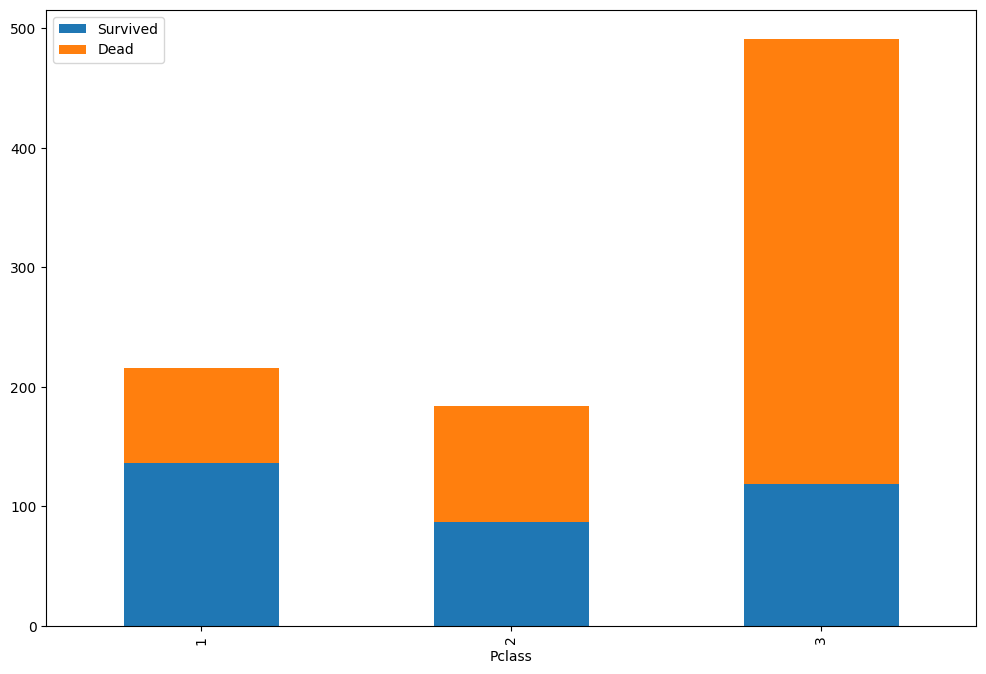

In [22]:
# 시각화
# - 우리가 지금 궁금한 것이 뭘까
# - 생존 확률에 영향을 주는 요소가 뭔지
# - 코드 뭉치

survived = train[train['Survived'] == 1]['Pclass'].value_counts()
dead = train[train['Survived'] == 0]['Pclass'].value_counts()

# survived, dead
merged_df = pd.DataFrame({
    'Survived': survived,
    'Dead': dead
})

merged_df.plot(kind='bar', stacked=True, figsize=(12, 8))

In [19]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [23]:
def make_bar_chart(column_names: str):
    survived = train[train['Survived'] == 1][column_names].value_counts()
    dead = train[train['Survived'] == 0][column_names].value_counts()

    # survived, dead
    merged_df = pd.DataFrame({
        'Survived': survived,
        'Dead': dead
    })

    merged_df.plot(kind='bar', stacked=True, figsize=(12, 8))

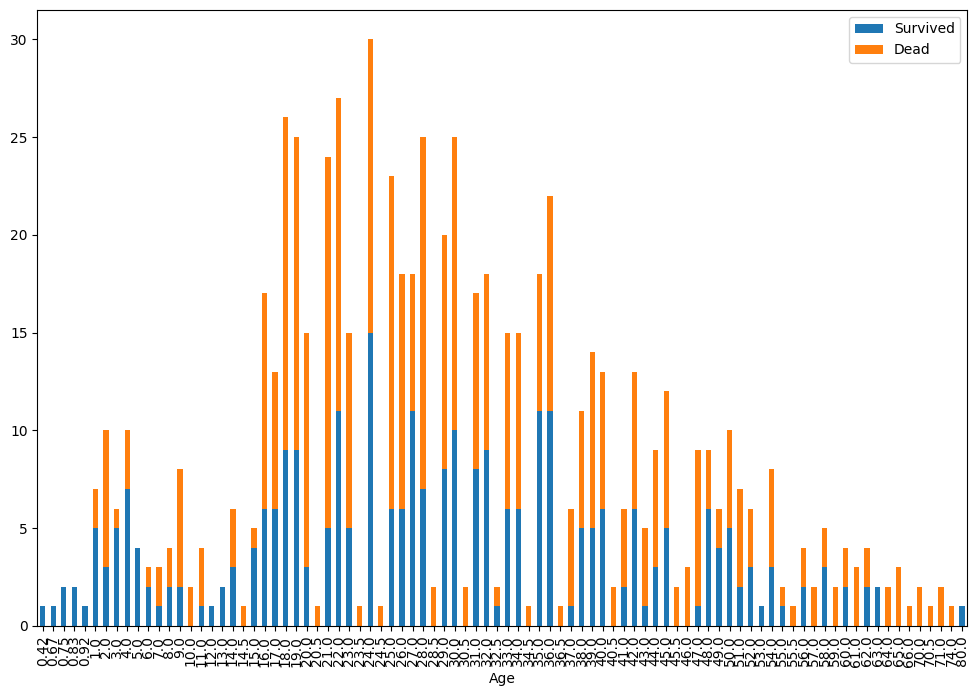

In [25]:
make_bar_chart('Age')

,Top 10 Fare,Bottom 10 Fare
Survived,,
0,0.3,0.9
1,0.7,0.1


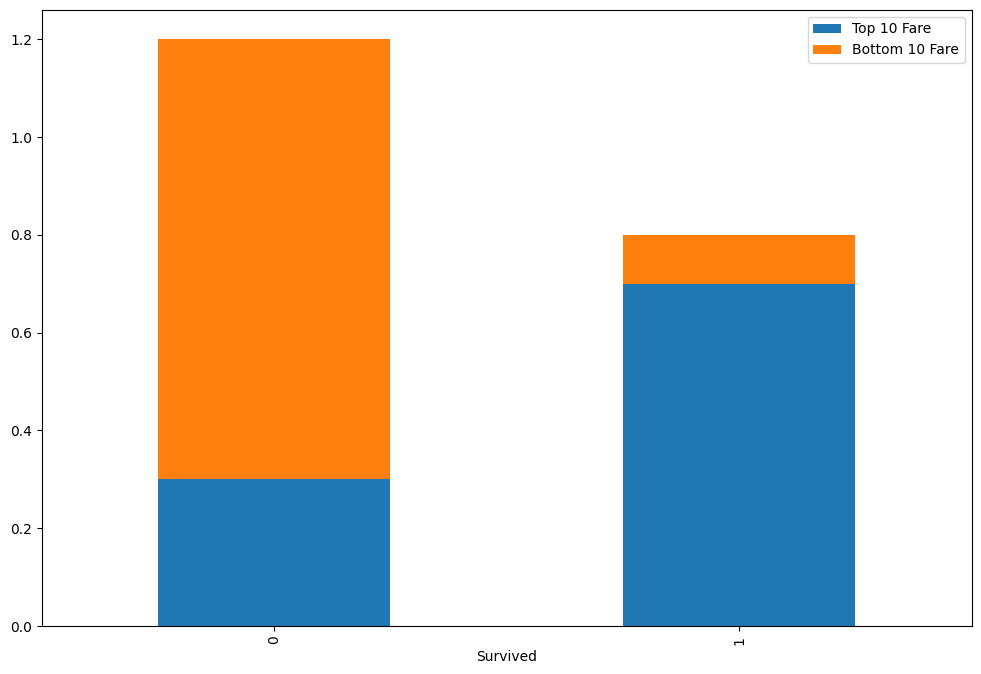

In [27]:
# 타이타닉에서 가장 돈 많이 낸 사람 10명, 가장 적게 낸 사람 10명의 생존확률 비교

# Fare 기준으로 정렬하여 가장 비싼 사람 10명과 가장 저렴한 사람 10명 추출
top_10_fare = train.nlargest(10, 'Fare')
bottom_10_fare = train.nsmallest(10, 'Fare')

# 각각의 생존확률 계산
top_10_survived = top_10_fare['Survived'].value_counts(normalize=True)
bottom_10_survived = bottom_10_fare['Survived'].value_counts(normalize=True)

# 데이터 병합
merged_df = pd.DataFrame({
    'Top 10 Fare': top_10_survived,
    'Bottom 10 Fare': bottom_10_survived
})

# NaN 값을 0으로 채움
merged_df = merged_df.fillna(0)

merged_df.plot(kind='bar', stacked=True, figsize=(12, 8))
merged_df

# 편의상 비즈니스, 이코노미라 칭함
# 비즈니스 석이 위층(사고나도 마지막에 가라앉는 위쪽 층), 이코노미 석이 아래 층에 있을 확률이 높고
# 사고 발생시에 비즈니스 층 인구밀집도가 이코노미 층보다 낮을 것이기 때문에 대피하기도 더 좋을 듯
# 그래서 비즈니스 이용자가 더 많이 살아남은 듯 하다

<Axes: title={'center': 'Survival Probability of Passengers Aged 65 and Above'}, ylabel='Probability'>

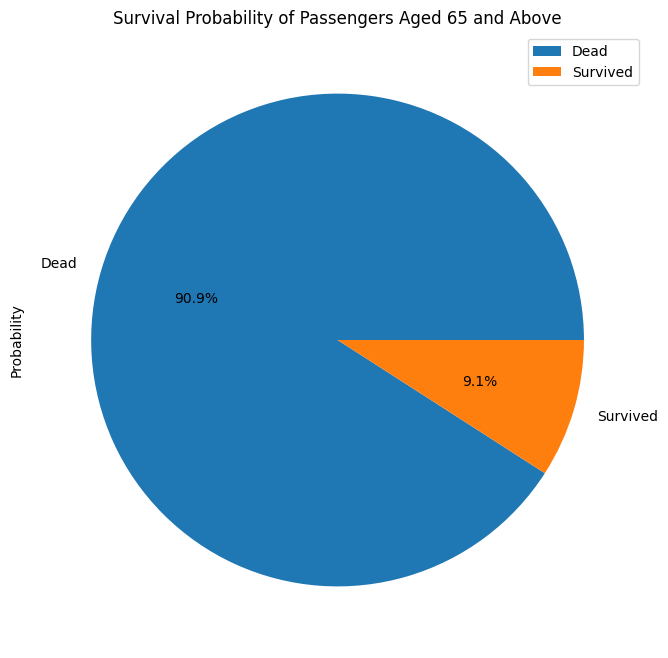

In [29]:
# 65세 이상의 승객 데이터 필터링
elderly_passengers = train[train['Age'] >= 65]

# 65세 이상 승객의 생존 확률 계산
elderly_survival = elderly_passengers['Survived'].value_counts(normalize=True)

# DataFrame으로 변환
elderly_survival_df = pd.DataFrame({
    'Probability': elderly_survival
})

# 인덱스 값에 따라 라벨 설정
elderly_survival_df.index = ['Dead', 'Survived']

# 원형 차트 시각화
elderly_survival_df.plot(kind='pie', y='Probability', autopct='%1.1f%%', figsize=(8, 8), title='Survival Probability of Passengers Aged 65 and Above')

# 노년층 생존율이 아주 낮다.
# 좀 더 연령대를 나눠서 아래에서 보자

/tmp/ipykernel_51056/1110351993.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_survival = train.groupby('AgeGroup')['Survived'].value_counts(normalize=True).unstack()


<Axes: title={'center': 'Survival Rate by Age Group'}, xlabel='AgeGroup'>

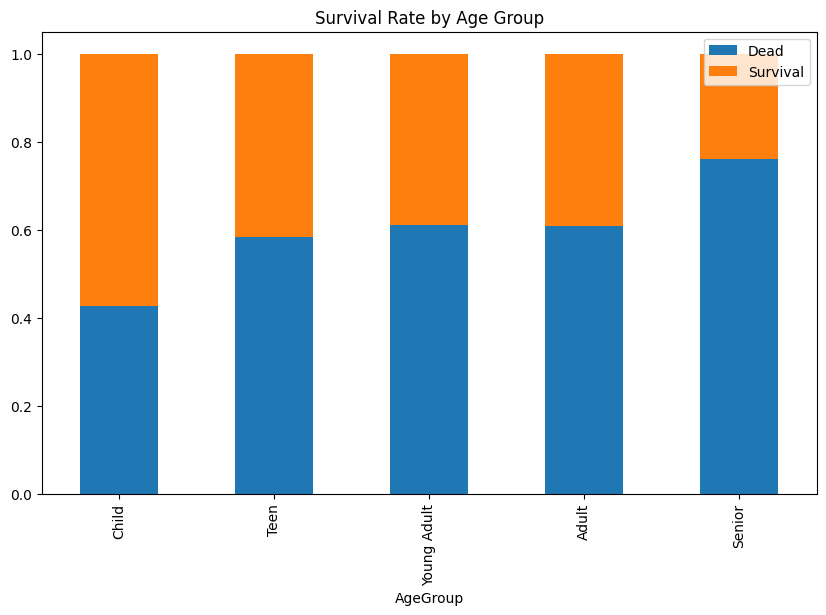

In [37]:
# 연령대별 생존율 분석을 위해 연령대 그룹화
# 한국에서는 청년이 39세 까지이기 때문에 39까지
# 그 이후는 그냥 임의로 했다.

bins = [0, 12, 20, 39, 60, 80]
labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)

# 각 연령대별 생존 확률 계산
age_group_survival = train.groupby('AgeGroup')['Survived'].value_counts(normalize=True).unstack()

# NaN 값을 0으로 채움
age_group_survival = age_group_survival.fillna(0)

# 열 이름을 생존과 사망으로 변경
age_group_survival.columns = ['Dead', 'Survival']

# 바 차트 시각화
age_group_survival.plot(kind='bar', stacked=True, figsize=(10, 6), title='Survival Rate by Age Group')

# 우선 어린이 생존율이 가장 높고 시니어가 가장 낮다.
# 보통 이런 사고 발생 시 국제사회 국룰로 어린이와 여자가 구출 1순위 이다.
# 그래서 어린이 ~ teen쪽 생존 확률이 가장 높을 것이다
# 그 이후에 구출 우선순위가 밀린, 신체적으로 기능이 저하된 노년 층의 생존율이 제일 낮은 걸로 생각된다.
